## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
import umap
from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise_distances_argmin_min
import plotly.express as px

## Load and Inspect the Data

In [2]:
df = pd.read_csv('../data/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
df.shape

(8807, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


We drop the 'show_id' column because it a duplicate of the DataFrame's actual index + 1 and adds no useful information

In [5]:
df.drop(columns='show_id', inplace=True)
df.shape

(8807, 11)

## Identify and Remove Duplicated Rows

In [6]:
duplicates = df.duplicated(keep=False) # Identify duplicate rows across all columns.
print(df[duplicates]) # View duplicate rows (if any)
duplicates.sum() #Count of how many duplicated rows

Empty DataFrame
Columns: [type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description]
Index: []


np.int64(0)

There are no duplicated rows

## Identify NaN values

In [7]:
print(pd.concat([df.isna().any(), df.isna().sum()], axis = 1).reset_index().rename(columns={
                'index': 'column_name',
                0: 'contains_na',
                1: 'na_count'
            }))

     column_name  contains_na  na_count
0           type        False         0
1          title        False         0
2       director         True      2634
3           cast         True       825
4        country         True       831
5     date_added         True        10
6   release_year        False         0
7         rating         True         4
8       duration         True         3
9      listed_in        False         0
10   description        False         0


"type", "title", "release year", "listed_in" and "description" columns have no missing data (no na values)

In [8]:
df[df['duration'].isna()]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


We see that 3 rows have missing duration columns, because they have been wrongly filled under the rating column

In [9]:
df[df['rating'].isin(['74 min', '84 min', '66 min', np.nan])]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...
5989,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
6827,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
7312,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
7537,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


There are 7 rows with ratings wrongly filled with the show's duration or have missing durations.

These wrongly filled rows also correspond to the same rows with missing duration values

In [10]:
df['duration'] = df['duration'].fillna(df['rating']) #Populate missing 'duration' values using correctly placed data found in the 'rating' column.
df.loc[df['rating'].isin(['74 min', '84 min', '66 min']), 'rating'] = np.nan #Set wrong rating values to nan

In [11]:
df['duration'].isna().sum()

np.int64(0)

The remaining columns with missing data are categorical. To maintain dataset integrity without dropping rows, we shall impute NaN values with the string 'Unknown'.

## Replacing NaN values with 'Unknown'

In [12]:
def replace_na(entry):
    if pd.isna(entry):
        return 'Unknown'
    return entry

In [13]:
columns_with_nan = [col for col in df.columns if df[col].isna().any()]
columns_with_nan

['director', 'cast', 'country', 'date_added', 'rating']

In [14]:
for col in columns_with_nan:
    df[col] = df[col].apply(replace_na)

In [15]:
#Check if we have replaced NaN values sucessfully
print(pd.concat([df.isna().any(), df.isna().sum()], axis = 1).reset_index().rename(columns={
                'index': 'column_name',
                0: 'contains_na',
                1: 'na_count'
            }))

     column_name  contains_na  na_count
0           type        False         0
1          title        False         0
2       director        False         0
3           cast        False         0
4        country        False         0
5     date_added        False         0
6   release_year        False         0
7         rating        False         0
8       duration        False         0
9      listed_in        False         0
10   description        False         0


All columns have no more NaN values

## Extract date components from "Date Added" Column

In [16]:
date_components = pd.to_datetime(df['date_added'], errors='coerce')

df['year_added'] = date_components.dt.year.astype('Int64')
df['month_added'] = date_components.dt.month.astype('Int64')
df['day_added'] = date_components.dt.day.astype('Int64')
df['day_of_week_added'] = date_components.dt.day_of_week.astype('Int64')

In [17]:
df[['year_added', 'month_added', 'day_added', 'day_of_week_added']]

,year_added,month_added,day_added,day_of_week_added
0,2021,9,25,5
1,2021,9,24,4
2,2021,9,24,4
3,2021,9,24,4
4,2021,9,24,4
...,...,...,...,...
8802,2019,11,20,2
8803,2019,7,1,0
8804,2019,11,1,4
8805,2020,1,11,5


## Further Data Cleaning

In [18]:
df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

##### There are only two types of videos on Netflix, Movie or TV Show

In [19]:
print(df[df['type'] == 'Movie']['duration'].unique())
print(df[df['type'] == 'TV Show']['duration'].unique())

['90 min' '91 min' '125 min' '104 min' '127 min' '67 min' '94 min'
 '161 min' '61 min' '166 min' '147 min' '103 min' '97 min' '106 min'
 '111 min' '110 min' '105 min' '96 min' '124 min' '116 min' '98 min'
 '23 min' '115 min' '122 min' '99 min' '88 min' '100 min' '102 min'
 '93 min' '95 min' '85 min' '83 min' '113 min' '13 min' '182 min' '48 min'
 '145 min' '87 min' '92 min' '80 min' '117 min' '128 min' '119 min'
 '143 min' '114 min' '118 min' '108 min' '63 min' '121 min' '142 min'
 '154 min' '120 min' '82 min' '109 min' '101 min' '86 min' '229 min'
 '76 min' '89 min' '156 min' '112 min' '107 min' '129 min' '135 min'
 '136 min' '165 min' '150 min' '133 min' '70 min' '84 min' '140 min'
 '78 min' '64 min' '59 min' '139 min' '69 min' '148 min' '189 min'
 '141 min' '130 min' '138 min' '81 min' '132 min' '123 min' '65 min'
 '68 min' '66 min' '62 min' '74 min' '131 min' '39 min' '46 min' '38 min'
 '126 min' '155 min' '159 min' '137 min' '12 min' '273 min' '36 min'
 '34 min' '77 min' '60 min' 

We see that the duration of Movies are measured in minutes, and the duration of TV Shows are measured in seasons

The following command performs the following operations:

1. Removes whitespace at the beginning and end
2. Converts all duration strings to lowercase

In [20]:
df['duration'] = df['duration'].str.strip().str.lower()

In [21]:
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(int)

In [22]:
df['movie_mins'] = np.where(df['type'] == 'Movie', df['duration_num'], np.nan)
df['movie_mins'] = df['movie_mins'].astype('Int64')

df['tv_seasons'] = np.where(df['type'] == 'TV Show', df['duration_num'], np.nan)
df['tv_seasons'] = df['tv_seasons'].astype('Int64')

In [23]:
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added,day_of_week_added,duration_num,movie_mins,tv_seasons
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9,25,5,90,90,<NA>
1,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9,24,4,2,<NA>,2
2,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,"September 24, 2021",2021,TV-MA,1 season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9,24,4,1,<NA>,1
3,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,"September 24, 2021",2021,TV-MA,1 season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,9,24,4,1,<NA>,1
4,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,9,24,4,2,<NA>,2


## Data Exploration

C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\2828240742.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




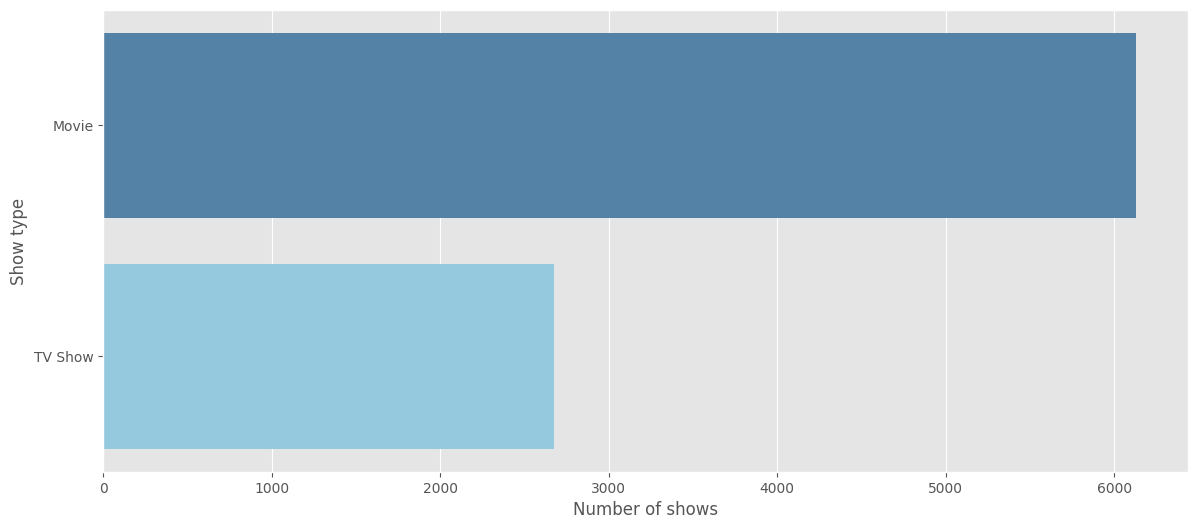

In [45]:
#This permenantly sets the figsize of all plots forward to be of size (8, 6)
plt.rcParams['figure.figsize'] = [14, 6]
plt.style.use('ggplot')

sns.countplot(df['type'], palette=['steelblue', 'skyblue'])
plt.ylabel("Show type")
plt.xlabel('Number of shows')
plt.savefig('../EDA Visualisations/show_type_countplot')

There are many more Movies (around 6.2k) than TV Shows (around 2.6k) on Netflix

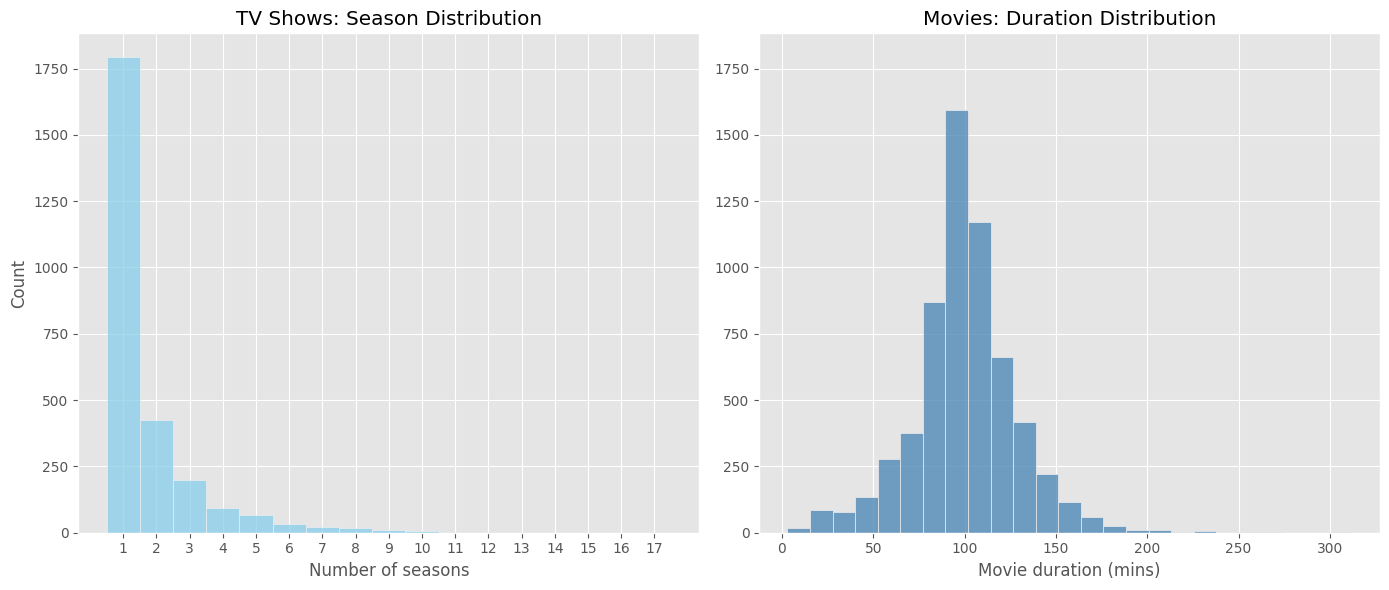

In [47]:
fig, ax = plt.subplots(ncols = 2, sharey= True)

seasons_xticks = np.arange(1, np.max(df['tv_seasons']) + 1, 1)
sns.histplot(df['tv_seasons'], ax = ax[0], discrete= True, color = 'skyblue')

ax[0].set_xticks(seasons_xticks)
ax[0].set_title('TV Shows: Season Distribution')
ax[0].set_xlabel('Number of seasons')

sns.histplot(df['movie_mins'], bins = 25, ax = ax[1], color = 'steelblue')
ax[1].set_title('Movies: Duration Distribution')
ax[1].set_xlabel('Movie duration (mins)')
ax[1].tick_params(labelleft=True)   

plt.tight_layout()
plt.savefig('../EDA Visualisations/show_type_histograms')

The distribution of TV show durations is highly right-skewed, indicating that majority of TV shows are short-lived. Most TV shows on Netflix only have 1 season (~1,800 titles), about 4.5 times the number of two-season TV shows. 
This frequency declines sharply for shows with more than two seasons, with very few series exceeding 10 seasons.

The duration of Movies follow an approximately normal distribution, with movies averaging around a duration of 100 minutes. 
Most movies last between 80 and 120 minutes, but there are still a substantial number of movies under 50 minutes (at least 100 movies) and movies longer than 150 minutes (at least 100 too).

In [26]:
df[df['year_added'].isna()]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added,day_of_week_added,duration_num,movie_mins,tv_seasons
6066,TV Show,A Young Doctor's Notebook and Other Stories,Unknown,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,Unknown,2013,TV-MA,2 seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ...",<NA>,<NA>,<NA>,<NA>,2,<NA>,2
6079,TV Show,Abnormal Summit,"Jung-ah Im, Seung-uk Jo","Hyun-moo Jun, Si-kyung Sung, Se-yoon Yoo",South Korea,"August 4, 2017",2017,TV-PG,2 seasons,"International TV Shows, Korean TV Shows, Stand...","Led by a trio of Korean celebs, a multinationa...",<NA>,<NA>,<NA>,<NA>,2,<NA>,2
6174,TV Show,Anthony Bourdain: Parts Unknown,Unknown,Anthony Bourdain,United States,Unknown,2018,TV-PG,5 seasons,Docuseries,This CNN original series has chef Anthony Bour...,<NA>,<NA>,<NA>,<NA>,5,<NA>,5
6177,TV Show,忍者ハットリくん,Unknown,Unknown,Japan,"December 23, 2018",2012,TV-Y7,2 seasons,"Anime Series, Kids' TV","Hailing from the mountains of Iga, Kanzo Hatto...",<NA>,<NA>,<NA>,<NA>,2,<NA>,2
6213,TV Show,Bad Education,Unknown,"Jack Whitehall, Mathew Horne, Sarah Solemani, ...",United Kingdom,"December 15, 2018",2014,TV-MA,3 seasons,"British TV Shows, TV Comedies","A history teacher at the posh Abbey Grove, Alf...",<NA>,<NA>,<NA>,<NA>,3,<NA>,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,TV Show,The Tudors,Unknown,"Jonathan Rhys Meyers, Henry Cavill, James Frai...","Ireland, Canada, United States, United Kingdom","January 8, 2018",2010,TV-MA,4 seasons,TV Dramas,All the splendor and scandal of England's 16th...,<NA>,<NA>,<NA>,<NA>,4,<NA>,4
8557,TV Show,The West Wing,Unknown,"Martin Sheen, Rob Lowe, Allison Janney, John S...",United States,"December 25, 2015",2005,TV-14,7 seasons,TV Dramas,This powerful political epic chronicles the tr...,<NA>,<NA>,<NA>,<NA>,7,<NA>,7
8684,TV Show,Vroomiz,Unknown,"Joon-seok Song, Jeong-hwa Yang, Sang-hyun Um, ...",South Korea,"August 1, 2017",2016,TV-Y,3 seasons,"Kids' TV, Korean TV Shows","For these half-car, half-animal friends, each ...",<NA>,<NA>,<NA>,<NA>,3,<NA>,3
8712,TV Show,Weird Wonders of the World,Unknown,Chris Packham,United Kingdom,"March 31, 2017",2016,TV-PG,2 seasons,"British TV Shows, Docuseries, Science & Nature TV",From animal oddities and bizarre science to me...,<NA>,<NA>,<NA>,<NA>,2,<NA>,2


C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\1937715338.py:25: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.27  4.73  5.73  6.73  7.73  8.73  9.73 10.73 11.73 12.73]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,year_added,type,count,x_pos
0,2008,Movie,1,0.00
1,2008,TV Show,1,-0.27
24,2008,Total,2,0.27
2,2009,Movie,2,1.00
25,2009,Total,2,1.27
3,2010,Movie,1,2.00
26,2010,Total,1,2.27
4,2011,Movie,13,3.00
27,2011,Total,13,3.27
5,2012,Movie,3,4.00


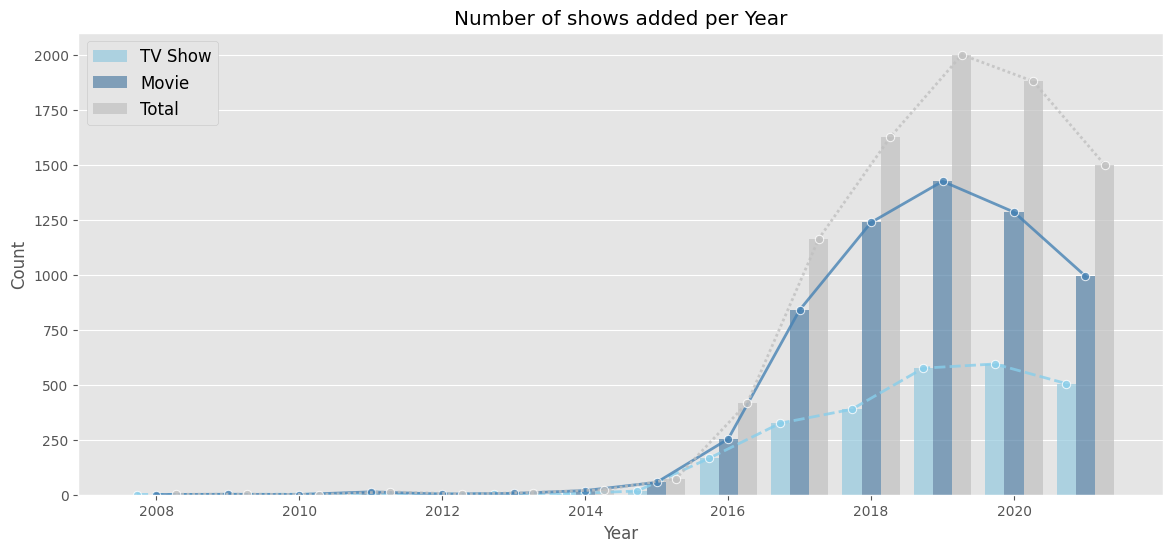

In [48]:
#Color palette for our types
palette = ['skyblue', 'steelblue', 'silver']


#Aggregate counts by year and type
show_counts_per_year = df.groupby(['year_added', 'type']).size().reset_index(name='count')
temp = df.groupby(by = 'year_added').size().reset_index(name = 'count')
temp['type'] = 'Total'
show_counts_per_year = pd.concat([show_counts_per_year, temp]).reset_index(drop = True)
show_counts_per_year = show_counts_per_year.sort_values(by=['year_added', 'count'], ascending=True)


#Create side by side bar plot
ax2 = sns.barplot(data=show_counts_per_year, x='year_added', y = 'count', hue = 'type',
                   hue_order = ['TV Show', 'Movie', 'Total'], palette=palette, alpha = 0.7)


# Map numeric years to their categorical x-axis indices for overlaying lineplot
unique_years = sorted(df['year_added'].dropna().unique())
year_map = {year: i for i, year in enumerate(unique_years)}
show_counts_per_year['x_pos'] = show_counts_per_year['year_added'].map(year_map)


#Offset the bars so that the centers of the bars align with the markers of the overlaying lineplot
show_counts_per_year.loc[show_counts_per_year['type'] == 'TV Show', 'x_pos'] -= 0.27
show_counts_per_year.loc[show_counts_per_year['type'] == 'Total', 'x_pos'] += 0.27


#Overlay lineplot over the barplot using the mapped x_pos
lines = sns.lineplot(data=show_counts_per_year, x='x_pos', y='count', hue = 'type', 
             hue_order=['TV Show', 'Movie', 'Total'],
             marker='o', legend=False, alpha = 0.8, linewidth = 2, 
             palette=palette,
             style='type')


#Change x ticks to only display years in step size of 2
tick_indices = [i for i, year in enumerate(unique_years) if year % 2 == 0]
tick_labels = [year for year in unique_years if year % 2 == 0]
ax2.set_xticks(tick_indices)
ax2.set_xticklabels(tick_labels)


plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of shows added per Year')
plt.legend(loc = 'upper left', fontsize = 12, frameon = True, framealpha = 1)
plt.savefig('../EDA Visualisations/movie_vs_tv_growth_trend')

show_counts_per_year

We see that the number of shows (both Movies and TV Shows) added on Netflix started to increase from 2014 onwards and sharply rose from 2016 onwards. The increase in Movies added is substantially higher than the increase in TV Shows evident from the steep gradient of the line.

We do see a decrease in Movies added from 2019 to 2020, presumably due to Covid19. However, the number of TV Shows added during this same period actually increased. Both Movies and TV Shows added eventually decreased from 2020 to 2021.

The total number of shows on Netflix rose sharply from 2016 onwards, butt started to see a decrease from 2019 - 2021 presumably due to Covid19 too.

In [28]:
print(np.max(date_components)) #Lastest date of a show being added in the dataset
print(np.min(date_components)) #Earliest date of a show being added in the dataset

2021-09-25 00:00:00
2008-01-01 00:00:00


C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\2126941918.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




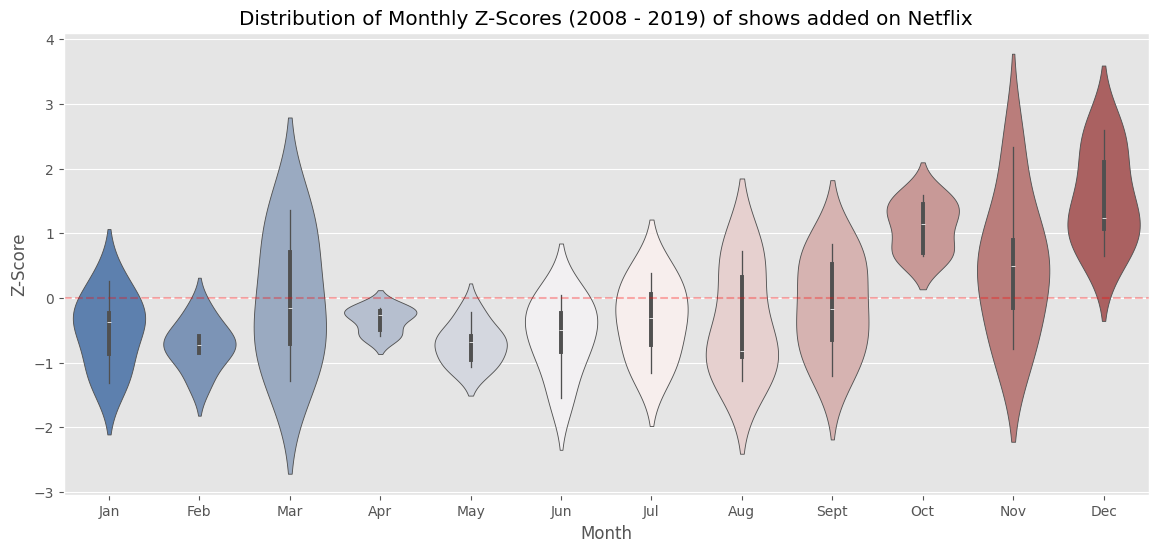

In [49]:
#Filter data before 2019 (pre-covid)
df_before_2019 = df[df['year_added'] < 2020]


#Group the data by year and month
monthly_counts_before_2019 = df_before_2019.groupby(['year_added', 'month_added']).size().reset_index(name='count')
monthly_counts_before_2019['Month'] = pd.to_datetime(monthly_counts_before_2019['month_added'], format='%m').dt.strftime('%b')


#Compute the Z scores for count of added shows for each month within each year. This accounts for a fair comparison of seasonality regardless of Netflix's growth over the years.
monthly_counts_before_2019['count_z'] = (monthly_counts_before_2019.groupby('year_added')['count']).transform(lambda x: (x - x.mean()) / x.std())

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


#Graph out the violin plot
ax3 = sns.violinplot(data=monthly_counts_before_2019, x='Month', y='count_z', palette='vlag', order = month_order)
plt.axhline(0, linestyle = '--', alpha = 0.3, color = 'red')

plt.ylabel('Z-Score')
plt.title('Distribution of Monthly Z-Scores (2008 - 2019) of shows added on Netflix')
plt.savefig('../EDA Visualisations/content_release_monthly_distribution')

From the violinplot, we see that the 4th Quarter in the months of Oct, Nov and Dec consistently sees the highest relative volume of additions of new shows, evident from their median Z-Scores of shows added being above the annual mean of 0. December stands out as the primary peak, with a median Z-score exceeding 1.0 and a high-density 'bulb' at the top of the violin, indicating that a significant release surge is a standard year-end practice.

Following the month of December, a noticeable cooldown period occurs during Jan and Feb, with their median Z-score fall below 0. This could be reasonably attributed to the large influx of new shows in December so the introduction of new shows is slowing down. 

A secondary, more volatile surge appears in March, characterized by a long upward tail; this indicates that while March is a major release window in some years, it is less consistent than the year-end surge. Following March, content additions stabilize or decrease until the cycle resets in October.

In [30]:
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'Unknown', 'NR', 'TV-Y7-FV', 'UR'],
      dtype=object)

rating_category
Adults     4009
Teens      3800
Kids        908
Unrated      90
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\3705094003.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




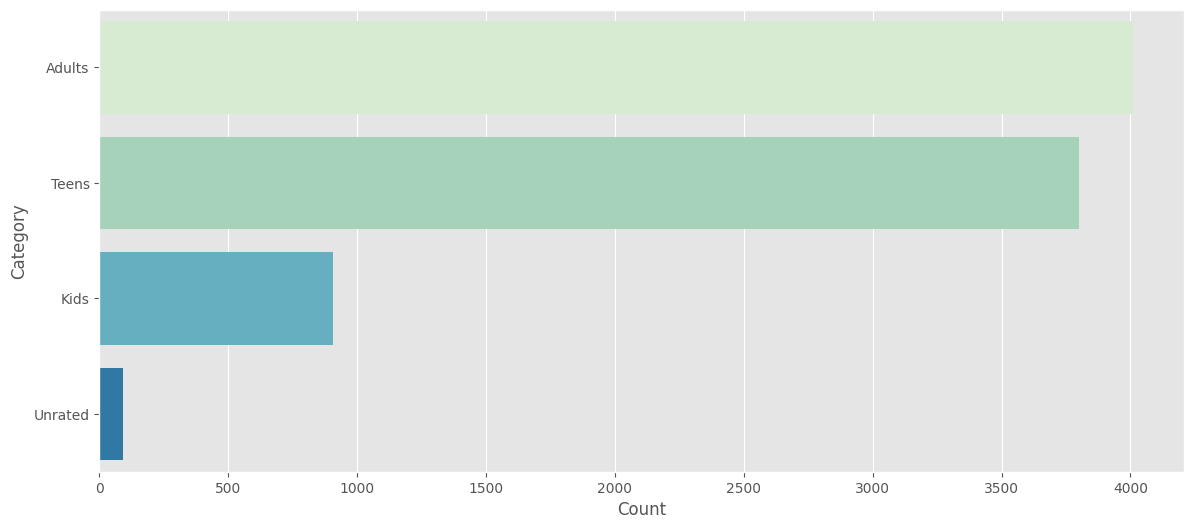

In [51]:
#Create rating map. Kids category are for ratings suggested for years 12 and below
# Teens category are for ratings suggested for years between 13 and 18, and adults are for years above 18.
rating_map = {
    'TV-G': 'Kids', 'TV-Y': 'Kids', 'G': 'Kids', 'TV-Y7': 'Kids', 'TV-Y7-FV': 'Kids',
    'TV-PG': 'Teens', 'PG': 'Teens', 'TV-14': 'Teens', 'PG-13': 'Teens',
    'TV-MA': 'Adults', 'R': 'Adults', 'NC-17': 'Adults',
    'NR': 'Unrated', 'UR': 'Unrated', 'Unknown': 'Unrated'
}

df['rating_category'] = df['rating'].map(rating_map)
ax4 = sns.countplot(df['rating_category'], order=['Adults', 'Teens', 'Kids', 'Unrated'], palette='GnBu')

plt.ylabel('Category')
plt.xlabel('Count')

print(df['rating_category'].value_counts())
plt.savefig('../EDA Visualisations/show_age_rating_countplot')

We see that most shows on Netflix are rated for Teens & Adults, with slightly more Adult shows (suggested for viewers 18 years and above) than Teens shows. There is about 8.6 times less shows for Kids than both Teens and Adults shows combined.

In [32]:
#Convert the df to long format for data visulisation
melted_df = df.melt(id_vars=['type', 'title', 'description'], 
               value_vars=['director', 'cast', 'country', 'listed_in'], value_name='value', var_name='category').drop_duplicates()


#Get rid of any trailing blank spaces
melted_df['value'] = melted_df['value'].str.strip()


#Split the string of directors/cast/country/listed_in (genres) into lists
melted_df['value'] = melted_df['value'].str.split(', ')


#"Explode" the list into individual rows
melted_df = melted_df.explode('value').drop_duplicates()

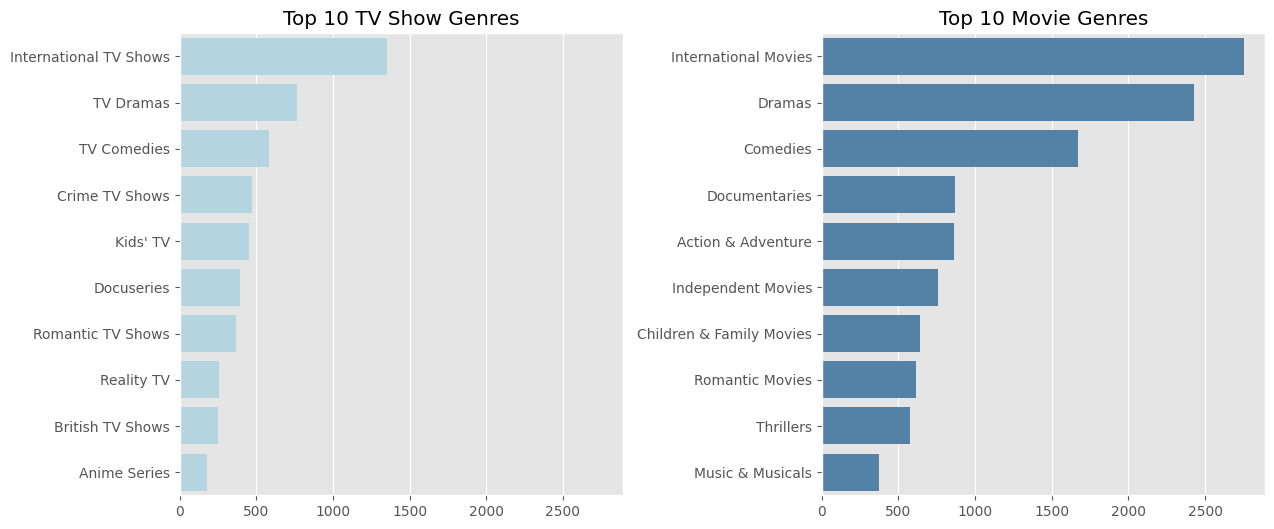

In [52]:
#Filter the melted dataframe to isolate genre categories
genres_df = melted_df[melted_df['category'] == 'listed_in']


#Split the genre data into separate subsets for Movies and TV Shows
movie_genres = genres_df[genres_df['type'] == 'Movie']
tv_genres = genres_df[genres_df['type'] == 'TV Show']

#Identify the top 10 most frequent genres for each content type
top_10_movie_genre = movie_genres['value'].value_counts(ascending=False).head(10)
top_10_tv_genre = tv_genres['value'].value_counts(ascending=False).head(10)


# Initialize a figure with two side-by-side subplots sharing the same x-axis scale
fig, ax5 = plt.subplots(ncols = 2, sharex=True)


# Plot the top 10 TV Show genres on the first subplot
sns.barplot(top_10_tv_genre, ax = ax5[0], orient= 'h', color = 'lightblue')

ax5[0].set_title('Top 10 TV Show Genres')
ax5[0].set_xlabel("")
ax5[0].set_ylabel("")


# Plot the top 10 Movie genres on the second subplot
sns.barplot(top_10_movie_genre, ax = ax5[1], orient= 'h', color = 'steelblue')

ax5[1].set_title('Top 10 Movie Genres')
ax5[1].set_xlabel("")
ax5[1].set_ylabel("")

#Adjust horizontal spacing between subplots to prevent overlapping labels
plt.subplots_adjust(wspace=0.45)
plt.savefig('../EDA Visualisations/top_10_genres_per_show_type')

The top 10 Genres in both TV Shows and Movies are quite similar. The top 3 genres for each show type are identical in genre and rank, with "International", "Dramas" and "Comedies" being the top 3.
Other common genres include Docuseries/Documentaries and Romance.

In [34]:
# Filter the melted DataFrame for rows belonging to the 'country' category and create a copy
countries_df = melted_df[melted_df['category'] == 'country'].copy()
countries_df['country'] = countries_df['value'].str.lower()


#URL for the GeoJSON file containing global geographic boundaries
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"

# Load the geographic data into a GeoDataFrame using geopandas
world = gpd.read_file(url)
world.head()

,name,ISO3166-1-Alpha-3,ISO3166-1-Alpha-2,geometry
0,Indonesia,IDN,ID,"MULTIPOLYGON (((117.70361 4.16342, 117.70361 4..."
1,Malaysia,MYS,MY,"MULTIPOLYGON (((117.70361 4.16342, 117.69711 4..."
2,Chile,CHL,CL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,BOL,BO,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,PER,PE,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [35]:
world['name'] = world['name'].str.lower()
world = world.sort_values(by = 'name')
# Display all unique country names in the geographic dataset
print(world.name.unique())

# Identify countries in the Netflix dataset that do not have a corresponding entry in the GeoJSON
no_matches = countries_df[~countries_df['country'].isin(world['name'])]['country'].unique()
print(f'No matches: {no_matches}')

['afghanistan' 'akrotiri sovereign base area' 'aland' 'albania' 'algeria'
 'american samoa' 'andorra' 'angola' 'anguilla' 'antarctica'
 'antigua and barbuda' 'argentina' 'armenia' 'aruba'
 'ashmore and cartier islands' 'australia' 'austria' 'azerbaijan'
 'bahrain' 'bajo nuevo bank (petrel is.)' 'bangladesh' 'barbados'
 'baykonur cosmodrome' 'belarus' 'belgium' 'belize' 'benin' 'bermuda'
 'bhutan' 'bir tawil' 'bolivia' 'bosnia and herzegovina' 'botswana'
 'brazil' 'brazilian island' 'british indian ocean territory'
 'british virgin islands' 'brunei' 'bulgaria' 'burkina faso' 'burundi'
 'cabo verde' 'cambodia' 'cameroon' 'canada' 'cayman islands'
 'central african republic' 'chad' 'chile' 'china' 'clipperton island'
 'colombia' 'comoros' 'cook islands' 'coral sea islands' 'costa rica'
 'croatia' 'cuba' 'curaçao' 'cyprus' 'cyprus no mans area' 'czechia'
 'democratic republic of the congo' 'denmark'
 'dhekelia sovereign base area' 'djibouti' 'dominica' 'dominican republic'
 'east timor' 'e

Clean up the country column

In [36]:
countries_df['country'] = countries_df['country'].str.rstrip(',')

# Define a dictionary to map Netflix country names to those found in the GeoJSON dataset
country_mapping = {
    'united states' : 'united states of america',
    'hong kong' : 'hong kong s.a.r.',
    'czech republic': 'czechia',
    'serbia': 'republic of serbia',
    'west germany': 'germany',
    'soviet union': 'russia',
    'vatican city': 'vatican',
    'east germany': 'germany',
    'bahamas': 'the bahamas',
    '': 'unknown'
}

#Apply mapping to country column
countries_df.loc[:, 'country'] = countries_df['country'].replace(country_mapping)
#Revert placeholder 'unknown' strings to actual NaN values for proper handling of missing data
countries_df['country'] = countries_df['country'].replace('unknown', np.nan)

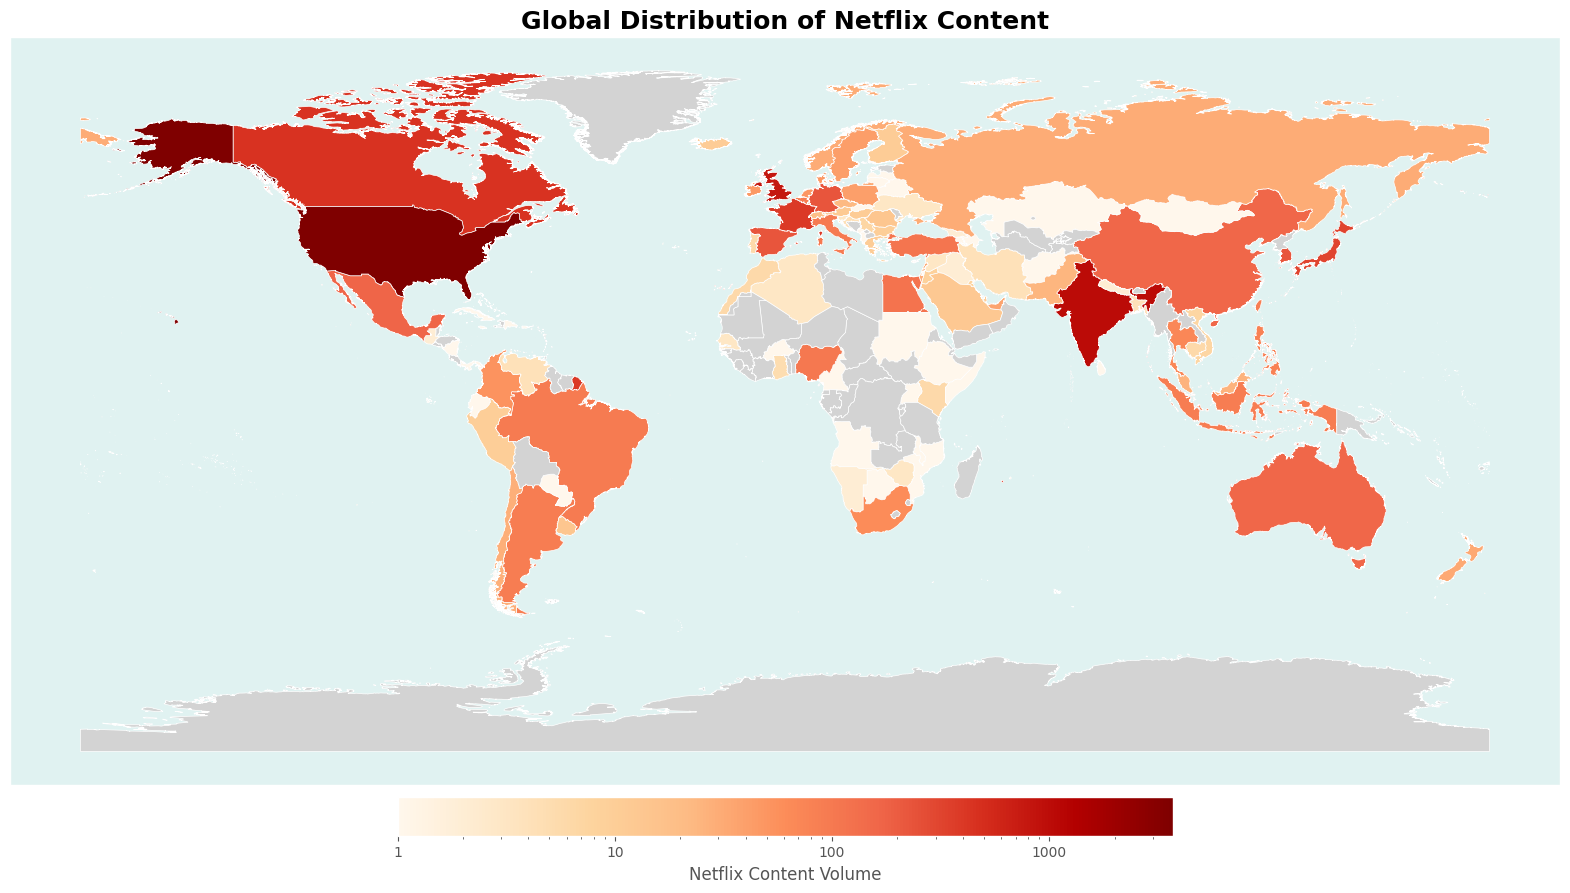

In [54]:
country_counts = countries_df.groupby('country').size().reset_index(name = 'count')
merged_world = world.merge(country_counts, left_on = 'name', right_on='country', how = 'left')

#Plot choropleth
ax6 = merged_world.plot(column='count',
                  edgecolor='white',
                  missing_kwds={
                      'color': "lightgray", 
                      'label': 'No Data'
                  },
                  legend_kwds={
                      'shrink': 0.5,
                      'pad': 0.01,
                      'fraction': 0.05,
                      'label': "Netflix Content Volume",
                      'orientation': "horizontal",
                      'format': "%.0f"
                  },
                  legend = True,
                  cmap='OrRd',
                  norm = colors.LogNorm(vmin=1, vmax=merged_world['count'].max()),
                  figsize=(20, 15))

ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_facecolor('#e0f2f1') # Very light blue/seafoam

plt.title('Global Distribution of Netflix Content', fontsize=18, fontweight = 'bold')
plt.savefig('../EDA Visualisations/global_content_distribution_choropleth', bbox_inches='tight', pad_inches=0.1)

From the choropleth we see that most shows on Netflix are produced in the US / Canada, which makes sense as Netflix is an American company and the US's media market is huge. The most prominent countries that shows are produced from are the US, India and the UK, which could be attributed to established film industries (Hollywood, Bollywood etc) in these countries.

Beyond these 3, countries in Asia (Japan, South Korea, China), South America (Brazil, Argentina) and Australia show higher content volumes compared to other countries. While there is a general correlation between larger nations and content volume, physical size is not the sole driver. For instance, Russia produces significantly less content than geographically smaller but culturally 'loud' nations like South Korea and Japan. For the case of Japan, this could be due to rising interest in Anime series on Netflix which is a top 10 genre within TV Shows.

We also see that the countries that produce the least (or no) content at all are concentrated within the Middle East and Africa.

In [38]:
# We combine description and genres so the NLP model captures both 'vibe' and 'category' of each show
def create_soup(x):
    return f"{x['description']} {x['listed_in']}"

# Replace 'Unknown' to '' to prevent embedding 'Unknown'
df['listed_in'] = df['listed_in'].str.lower().str.replace('unknown', '', regex=True)
df['soup'] = df.apply(create_soup, axis=1)

In [39]:
#Load a pre-trained, lightweight Sentence Transformer model from Hugging Face
model = SentenceTransformer('all-MiniLM-L6-v2')

#Create embeddings for each description + listed_in
embeddings = model.encode(df['soup'].tolist())

In [40]:
#Use UMAP to project 384-dimensional data into 2D space for visualization
umap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d = umap.fit_transform(embeddings)

c:\Users\Admin\OneDrive\Documents\Coding Projects\Netflix Shows EDA\netflix_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [41]:
#Split genres for shows with multiple genres
df['genre_list'] = df['listed_in'].str.split(', ')

#Explode the list so each genre gets its own row
df_exploded = df.explode('genre_list')

#Get rid of trailing white spaces and transform to lowercase
df_exploded['genre_list'] = df_exploded['genre_list'].str.strip().str.lower()

print(df_exploded['genre_list'].nunique()) #42 unique genres listed
print(df_exploded['genre_list'].value_counts())

42
genre_list
international movies            2752
dramas                          2427
comedies                        1674
international tv shows          1351
documentaries                    869
action & adventure               859
tv dramas                        763
independent movies               756
children & family movies         641
romantic movies                  616
tv comedies                      581
thrillers                        577
crime tv shows                   470
kids' tv                         451
docuseries                       395
music & musicals                 375
romantic tv shows                370
horror movies                    357
stand-up comedy                  343
reality tv                       255
british tv shows                 253
sci-fi & fantasy                 243
sports movies                    219
anime series                     176
spanish-language tv shows        174
tv action & adventure            168
korean tv shows         

In [42]:
#13 Genres we will include as landmarks on our visualisation
genre_list = [
    'dramas', 'comedies', 'documentaries', 'action & adventure', 
    'children & family', 'romance', 'thrillers', 'crime', 
    'music & musicals', 'horror', 'sci-fi & fantasy', 'anime', 'sports', 'stand-up comedy'
]

#Get all genres that contain Movie/Movies/TV in their name
filtered_genres = df_exploded[df_exploded['genre_list'].str.contains('movie|movies|tv', case=False, na=False)]['genre_list'].unique()
print(filtered_genres) 

# Mapping of genres listed in the df to pre-defined genres.
genre_mapping = {
    'tv dramas': 'dramas',
    'romantic movies': 'romance',
    'romantic tv shows': 'romance',
    'tv comedies': 'comedies',
    'stand-up comedy & talk shows': 'stand-up comedy',
    'tv action & adventure': 'action & adventure',
    'tv horror': 'horror',
    'horror movies' :'horror',
    'children & family movies': 'children & family',
    "kids' tv": 'children & family',
    'tv thrillers': 'thrillers',
    'tv sci-fi & fantasy': 'sci-fi & fantasy',
    'anime series': 'anime',
    'anime features': 'anime',
    'crime tv shows': 'crime',
    'docuseries': 'documentaries',
    'sports movies': 'sports'
}

#Rename genres to those listed in the mapping
df_exploded['genre_list'] = df_exploded['genre_list'].replace(genre_mapping)

['international tv shows' 'tv dramas' 'tv mysteries' 'crime tv shows'
 'tv action & adventure' 'reality tv' 'romantic tv shows' 'tv comedies'
 'tv horror' 'children & family movies' 'independent movies'
 'international movies' 'british tv shows' 'spanish-language tv shows'
 'romantic movies' 'horror movies' 'tv thrillers' "kids' tv"
 'tv sci-fi & fantasy' 'classic movies' 'sports movies' 'korean tv shows'
 'science & nature tv' 'teen tv shows' 'cult movies' 'tv shows'
 'lgbtq movies' 'movies' 'classic & cult tv']


In [43]:
#Add x and y embedded coordinates to the df for plotting
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]


#Map the coordinates to the exploded dataframe using the index
df_exploded['x'] = df_exploded.index.map(df['x'])
df_exploded['y'] = df_exploded.index.map(df['y'])


#Function to find the medoid (most central data point for each of our landmarks)
def find_genre_medoid(group):
    # Calculate the average center
    center = group[['x', 'y']].mean().values.reshape(1, -1)
    
    # Calculate the distance between medoids and every other point within the genre cluster
    # closest_idx is the positional index of the point closest to the medoid
    closest_idx, _ = pairwise_distances_argmin_min(center, group[['x', 'y']])
    
    # This keeps the genre name and the coordinates of the closest point to the medoid
    return group.iloc[closest_idx][['genre_list', 'x', 'y']]


# Group shows by genre and get medoids for each
landmarks = (df_exploded[df_exploded['genre_list'].isin(genre_list)]
             .groupby('genre_list')
             .apply(find_genre_medoid)
             .reset_index(drop=True))

C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\4223396905.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(find_genre_medoid)


In [55]:
#Create plotly interactive scatterplot
fig = px.scatter(df, x='x', y='y', color='type', 
                 hover_data={
                     'x': False,     
                     'y': False,           
                     'title': True,        
                     'country': True,      
                     'listed_in': True,
                     'description': True     
                 },
                 title="Interactive Netflix Content Map",
                 template='plotly_dark')

#Add the landmarks (genres) to the scatterplot
for _, row in landmarks.iterrows():
    fig.add_annotation(
        x=row['x'],
        y=row['y'],
        text=f"<b>{row['genre_list'].title()}</b>", 
        showarrow=False,
        yshift=10, 
        font=dict(
            size=12,
            color="white",
            family="Arial Black"  
        ),
        bgcolor="rgba(0,0,0,0.8)",
        bordercolor="white",
        borderwidth=1,
        borderpad=4,
        opacity=0.9
    )

# Remove axis titles and lines as the literal x/y values are not semantically meaningful
fig.update_layout(xaxis_title=None, yaxis_title=None, legend_title_text='Type')
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_traces(marker=dict(size=3, opacity=0.5))
fig.show()
fig.write_html("../EDA Visualisations/interactive_netflix_content_map.html")

The plotly scatterplot maps all shows in the dataset on a 2D graph. Each dot represents a show and shows that are closer together share similarities in genres or show descriptions. This was achieved through the Sentence Transformer 'all-MiniLM-L6-v2' from Hugging Faces, embedding each show using their descriptions and genres. UMAP algorithm was then utilised to reduce the embeddings to 2 dimensions (x and y dimensions) to be able to map each show on a 2D scatter plot. 

13 Major genres were selected from the top few genres with the highest value_counts() to be used as 'landmark genres', and have been placed on the map for easier navigation and discovery of shows of a particular genre.

One notable limitation is that certain titles lacked explicit genre labels, making it difficult to definitively categorize their primary themes. Furthermore, the brevity of some show descriptions provided limited semantic information for embedding. As a result, some shows may be positioned near a landmark genre that does not perfectly reflect their content. Despite these individual outliers, the overall map successfully forms cohesive clusters that align with the identified landmark genres.

## Data Sources & Credits

* Netflix Movies and TV Shows Dataset: Sourced from [Kaggle](https://www.kaggle.com/datasets/shivamb/netflix-shows) (provided by Shivam Bansal).

* Geospatial Data: World boundaries GeoJSON sourced from [datasets/geo-countries](https://github.com/datasets/geo-countries) on GitHub.